In [14]:
import pandas as pd
import numpy as np
import pymc3 as pm
import theano.tensor as tt
from theano import shared
import seaborn as sns
import model_tools

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.options.display.max_columns = 100

### Download data

In [3]:
data = pd.read_csv('http://www.football-data.co.uk/mmz4281/1617/E0.csv')

In [4]:
results, teams = model_tools.parse_data(data)

### Model creation

In [10]:
num_teams = len(teams)

home_team = shared(results.i_home.values)
away_team = shared(results.i_away.values)

observed_home_goals = results.fthg.values
observed_away_goals = results.ftag.values

In [11]:
with pm.Model() as model:
    # global model parameters
    home        = pm.Normal('home',      0, tau=.0001)
    tau_att     = pm.Gamma('tau_att',   .1, .1)
    tau_def     = pm.Gamma('tau_def',   .1, .1)
    intercept   = pm.Normal('intercept', 0, tau=.0001)

    # team-specific model parameters
    atts_star   = pm.Normal("atts_star",
                           mu   =0,
                           tau  =tau_att,
                           shape=num_teams)
    defs_star   = pm.Normal("defs_star",
                           mu   =0,
                           tau  =tau_def,
                           shape=num_teams)

    atts        = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs        = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_theta  = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta  = tt.exp(intercept + atts[away_team] + defs[home_team])

    # likelihood of observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_goals)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_goals)

Applied log-transform to tau_att and added transformed tau_att_log_ to model.
Applied log-transform to tau_def and added transformed tau_def_log_ to model.


In [12]:
with model:

    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(100000, step, start=start)

100%|██████████| 100000/100000 [41:01<00:00, 44.01it/s]


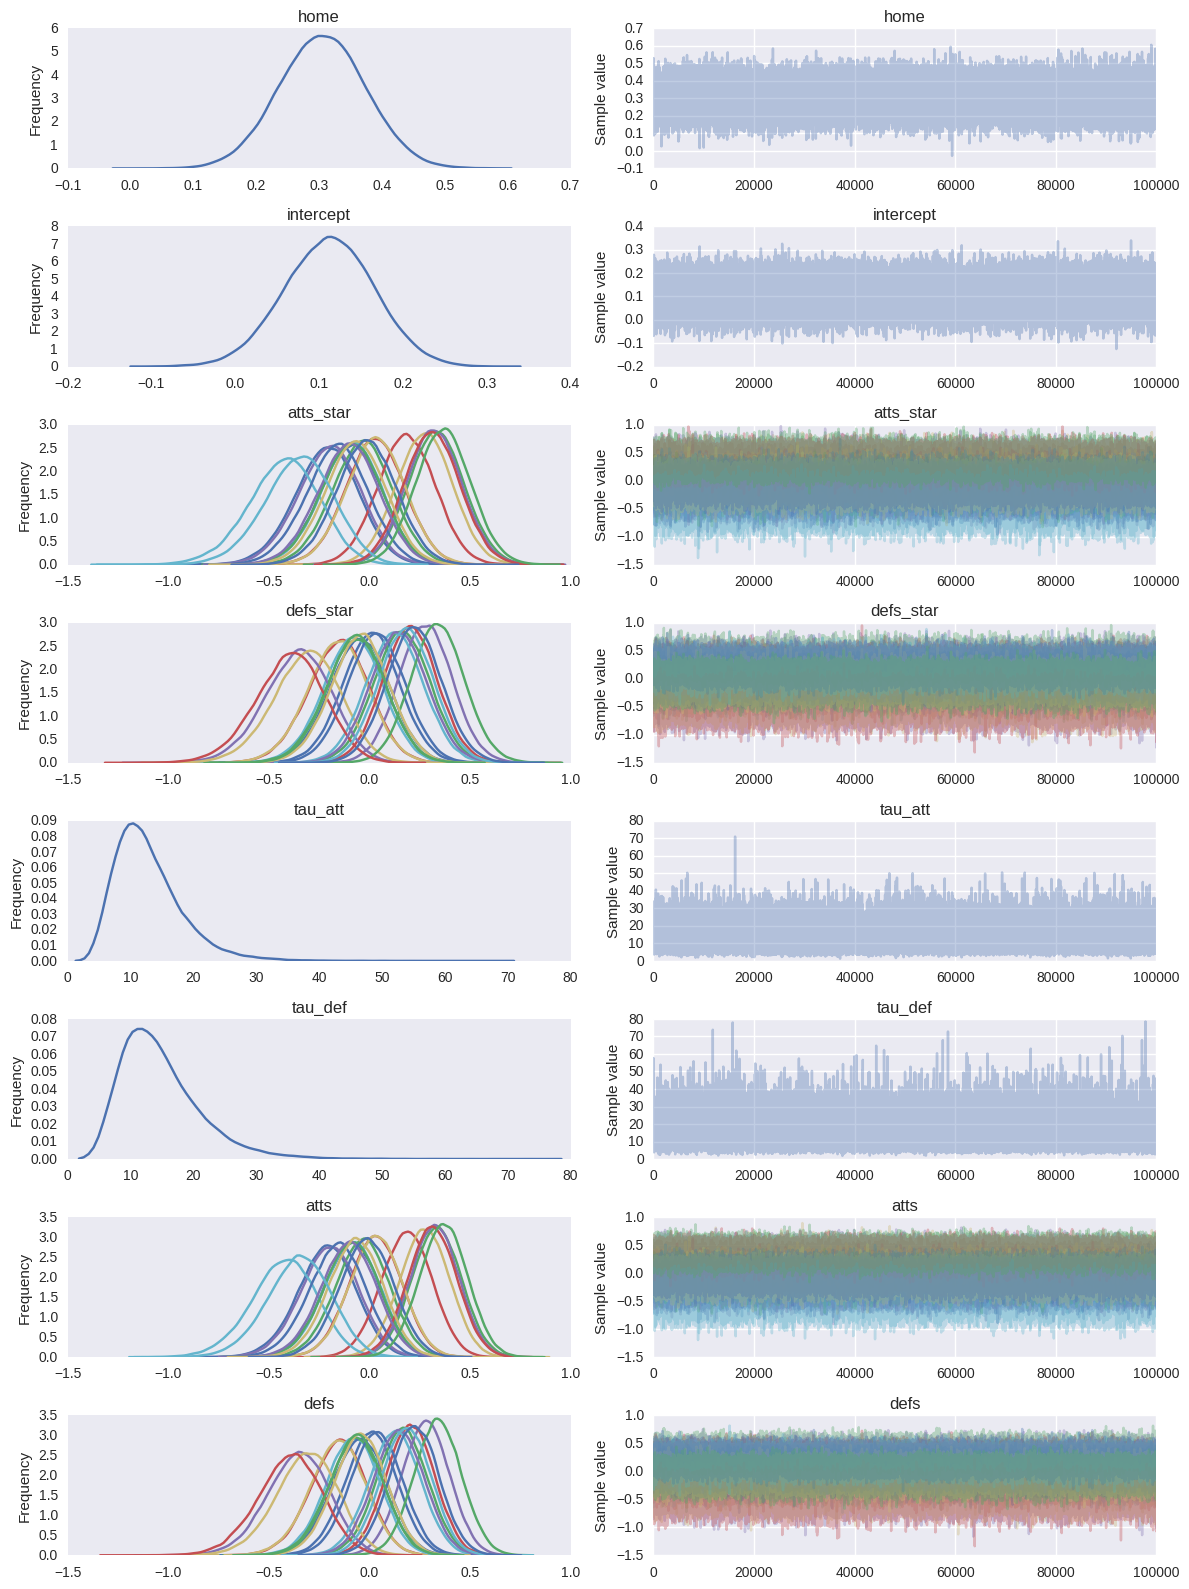

In [13]:
pm.traceplot(trace);

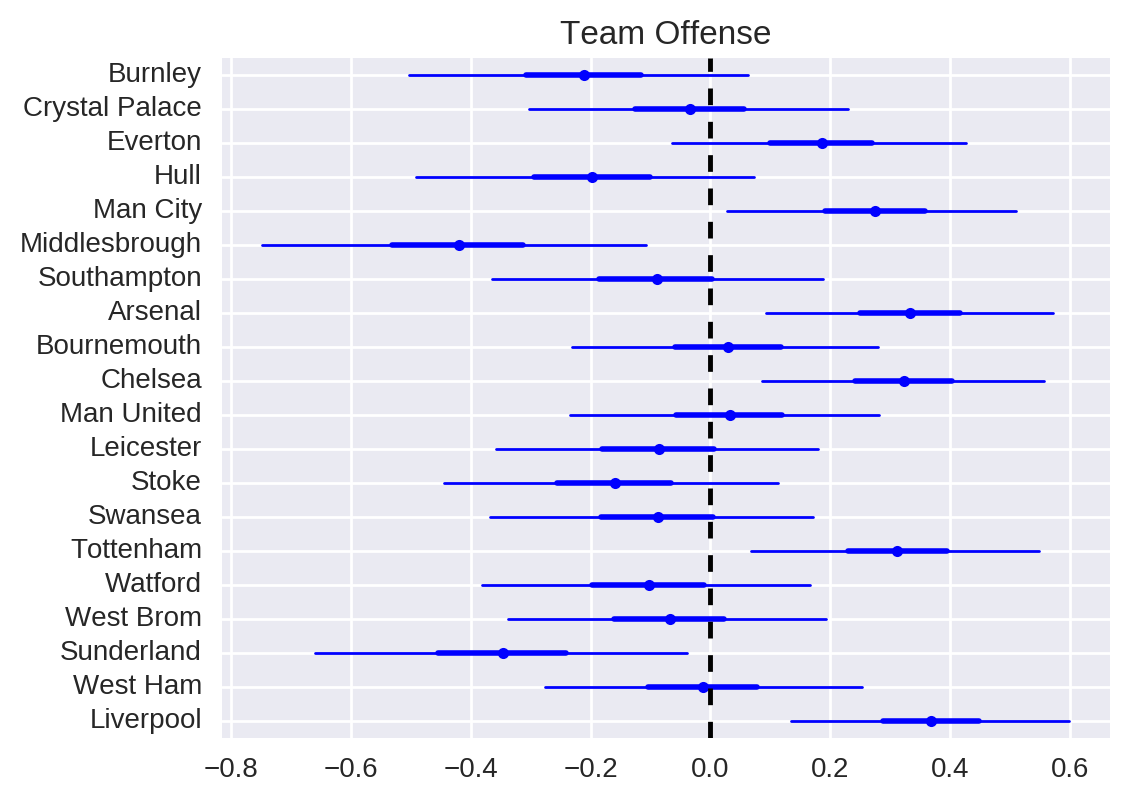

In [15]:
pm.forestplot(trace, varnames=['atts'], ylabels=teams['team'], main="Team Offense");

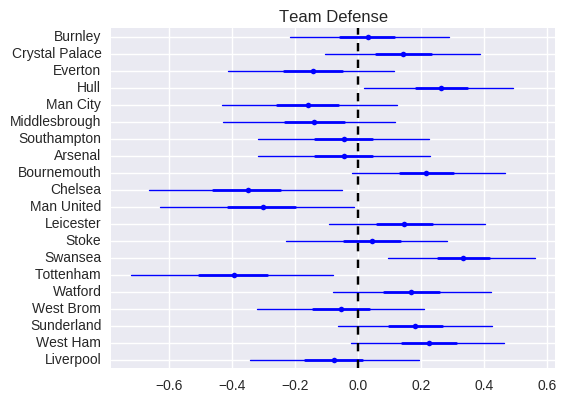

In [59]:
pm.forestplot(trace, varnames=['defs'], ylabels=teams['team'], main="Team Defense");

In [16]:
def predict_single_outcome(home, away, n=1000, payback=0.97):
    home_team.set_value([home])
    away_team.set_value([away])
    
    predictions = pm.sample_ppc(trace, samples=n, model=model)
    
    away = pd.DataFrame(predictions['away_points'], columns=['away'])
    home = pd.DataFrame(predictions['home_points'], columns=['home'])

    p_results = pd.concat([home, away], axis=1)
    
    p_results['total_goals'] = p_results.sum(axis=1)
    
    p_results['p_home'] = (p_results['home'] > p_results['away']).sum() / n
    p_results['p_draw'] = (p_results['home'] == p_results['away']).sum() / n
    p_results['p_away'] = (p_results['home'] < p_results['away']).sum() / n
    
    p_results['odds_home'] = payback / p_results['p_home']
    p_results['odds_draw'] = payback / p_results['p_draw']
    p_results['odds_away'] = payback / p_results['p_away']
    
    p_results['p_o0.5'] = (p_results['total_goals'] > 0.5).sum() / n
    p_results['p_o1.5'] = (p_results['total_goals'] > 1.5).sum() / n
    p_results['p_o2.5'] = (p_results['total_goals'] > 2.5).sum() / n
    p_results['p_o3.5'] = (p_results['total_goals'] > 3.5).sum() / n
    
    p_results['p_u0.5'] = (p_results['total_goals'] < 0.5).sum() / n
    p_results['p_u1.5'] = (p_results['total_goals'] < 1.5).sum() / n
    p_results['p_u2.5'] = (p_results['total_goals'] < 2.5).sum() / n
    p_results['p_u3.5'] = (p_results['total_goals'] < 3.5).sum() / n
    
    p_results['odds_o0.5'] = payback / p_results['p_o0.5']
    p_results['odds_o1.5'] = payback / p_results['p_o1.5']
    p_results['odds_o2.5'] = payback / p_results['p_o2.5']
    p_results['odds_o3.5'] = payback / p_results['p_o3.5']
    
    p_results['odds_u0.5'] = payback / p_results['p_u0.5']
    p_results['odds_u1.5'] = payback / p_results['p_u1.5']
    p_results['odds_u2.5'] = payback / p_results['p_u2.5']
    p_results['odds_u3.5'] = payback / p_results['p_u3.5']
    
    probs = p_results.iloc[:1, 3:]
    
    return probs

In [17]:
teams

,team,i
0,Burnley,0
1,Crystal Palace,1
2,Everton,2
3,Hull,3
4,Man City,4
5,Middlesbrough,5
6,Southampton,6
7,Arsenal,7
8,Bournemouth,8
9,Chelsea,9


In [29]:
probabilities = predict_single_outcome(home=1, away=7, n=10000, payback=0.97)

In [30]:
probabilities

,p_home,p_draw,p_away,odds_home,odds_draw,odds_away,p_o0.5,p_o1.5,p_o2.5,p_o3.5,p_u0.5,p_u1.5,p_u2.5,p_u3.5,odds_o0.5,odds_o1.5,odds_o2.5,odds_o3.5,odds_u0.5,odds_u1.5,odds_u2.5,odds_u3.5
0,0.2941,0.2267,0.4792,3.298198,4.278783,2.024207,0.9577,0.8289,0.6239,0.4121,0.0423,0.1711,0.3761,0.5879,1.012843,1.170226,1.554736,2.353798,22.931442,5.669199,2.579101,1.64994


In [26]:
probabilities2 = predict_single_outcome(home=2, away=11, n=10000, payback=0.97)

In [28]:
probabilities2

,p_home,p_draw,p_away,odds_home,odds_draw,odds_away,p_o0.5,p_o1.5,p_o2.5,p_o3.5,p_u0.5,p_u1.5,p_u2.5,p_u3.5,odds_o0.5,odds_o1.5,odds_o2.5,odds_o3.5,odds_u0.5,odds_u1.5,odds_u2.5,odds_u3.5
0,0.6377,0.2071,0.1552,1.521091,4.683728,6.25,0.9419,0.7818,0.5656,0.3528,0.0581,0.2182,0.4344,0.6472,1.029833,1.240727,1.714993,2.749433,16.695353,4.445463,2.232965,1.498764
